In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from datetime import date
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Exploratary data analysis (please change the file path according to your local settings)

In [230]:
df = pd.read_csv('desktop/Fetch/data_daily.csv', names = ['date', 'receipt_count'], header = 0)
df['date'] = pd.to_datetime(df['date'])

In [231]:
df

,date,receipt_count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289
...,...,...
360,2021-12-27,10350408
361,2021-12-28,10219445
362,2021-12-29,10313337
363,2021-12-30,10310644


In [232]:
months_start = df['date'][df['date'].dt.day == 1].values

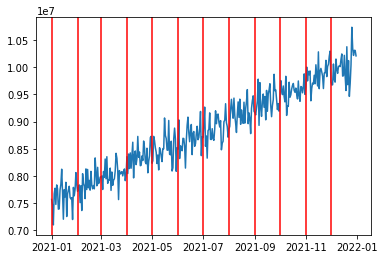

In [233]:
plt.plot(df['date'], df['receipt_count'])
for i in range(len(months_start)):
    plt.axvline(months_start[i], color='red')

### ^ From the figure above we have a high level idea of the data - the time series has a linear increasing trend with roughly month seasonality. (The red line represents the first day of each month)

## We have two options here, the first is that we directly predict the month's data based on historcial months. The second is to predict each day's value and sum them all to get the prediction for a whole month.

### Aggregate the data for each month

In [234]:
df_month = df.groupby(df.date.dt.month)['receipt_count'].sum()

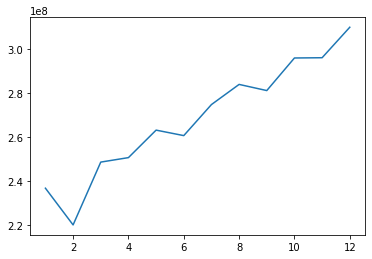

In [235]:
plt.plot(df_month)

### ^ In this way we only have 12 data and we've lost information about the daily pattern of data, which might not be a good idea here.

### Try to extract the trend and seasonal components

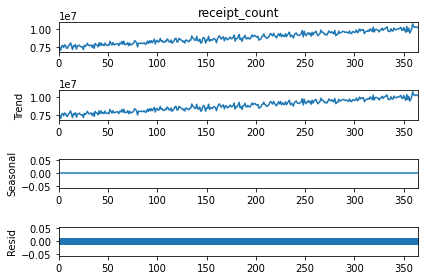

In [236]:
result = seasonal_decompose(df['receipt_count'], model='additive', period=1)
result.plot()
plt.show()

### Try some more advanced decomposition methods

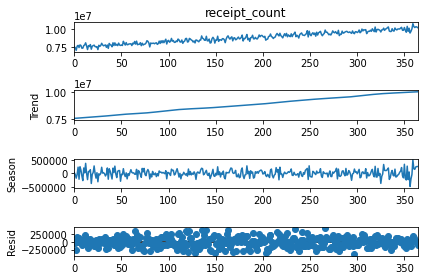

In [237]:
stl = STL(df['receipt_count'], period=31)
res = stl.fit()
fig = res.plot()

### See each month's daily data respectively

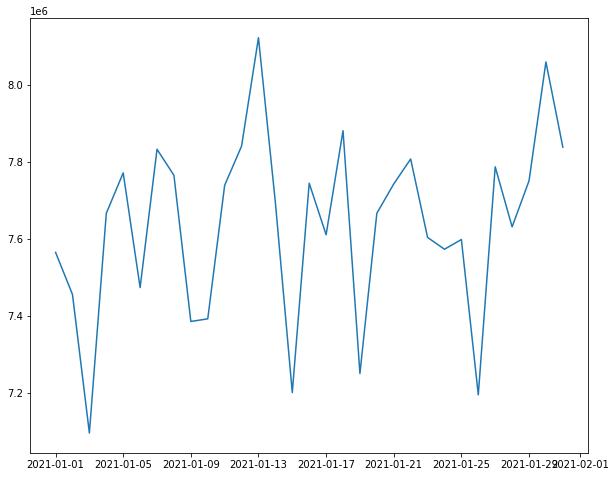

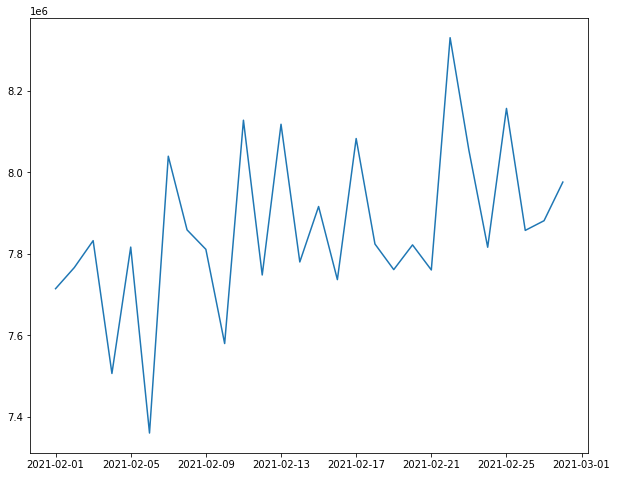

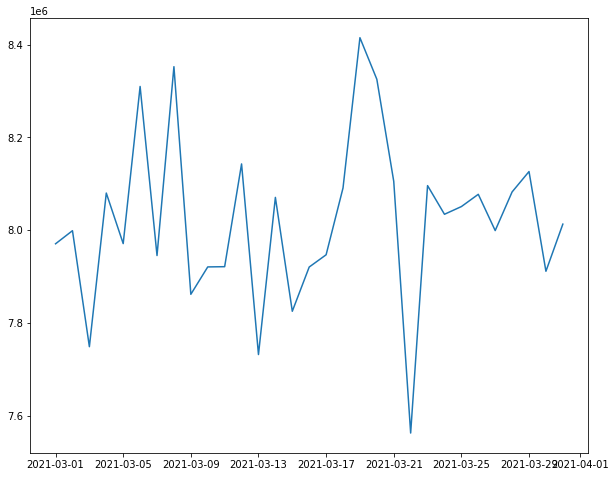

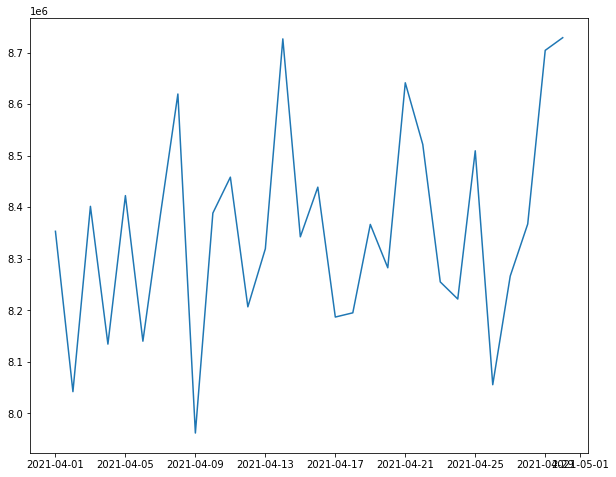

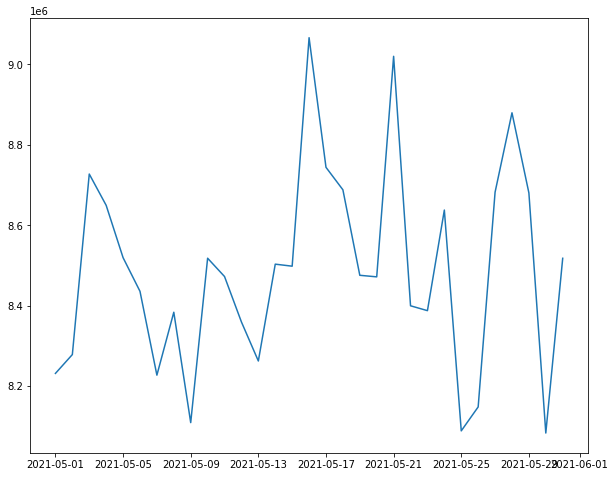

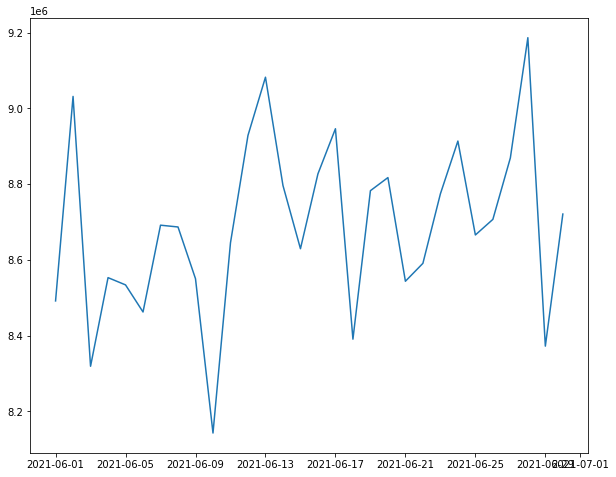

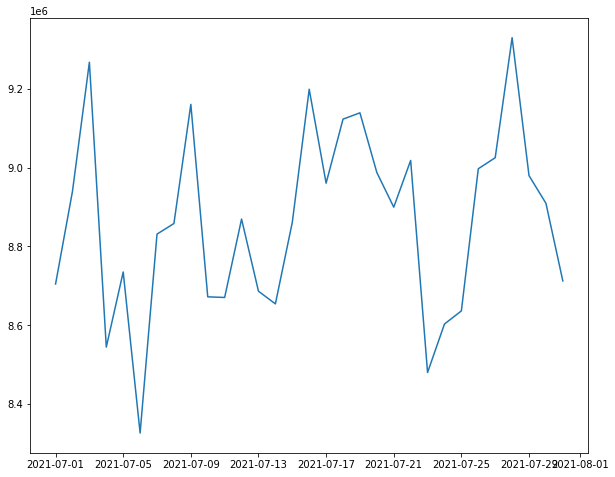

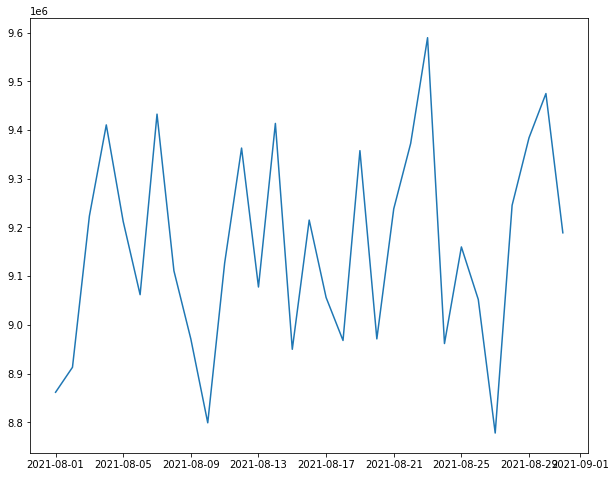

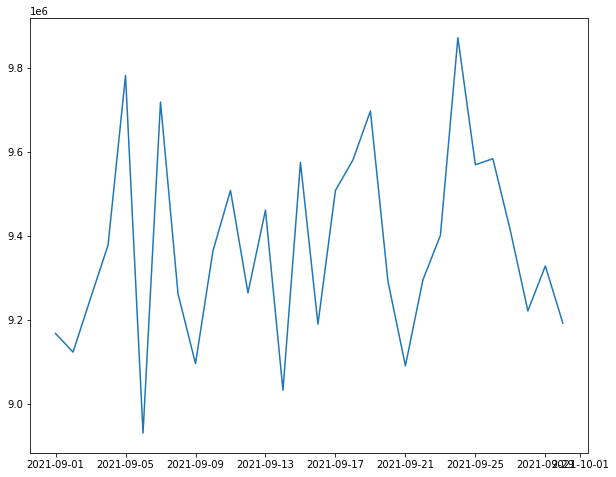

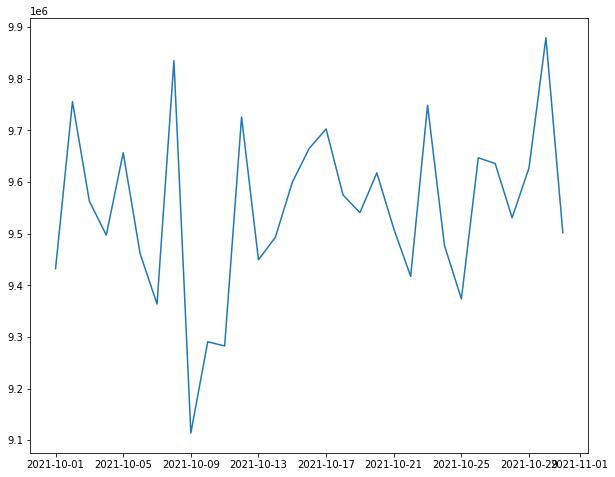

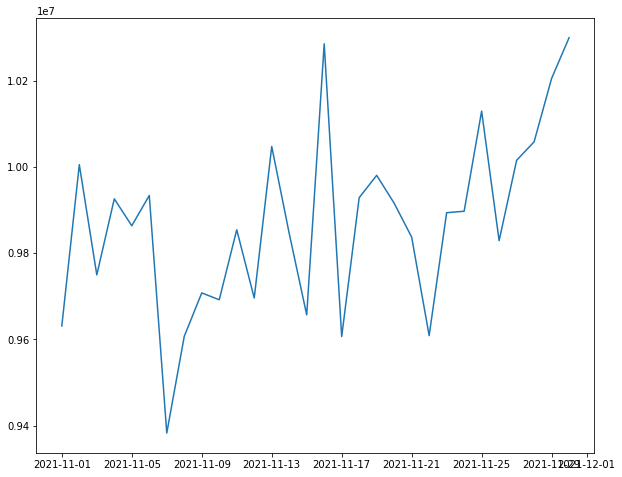

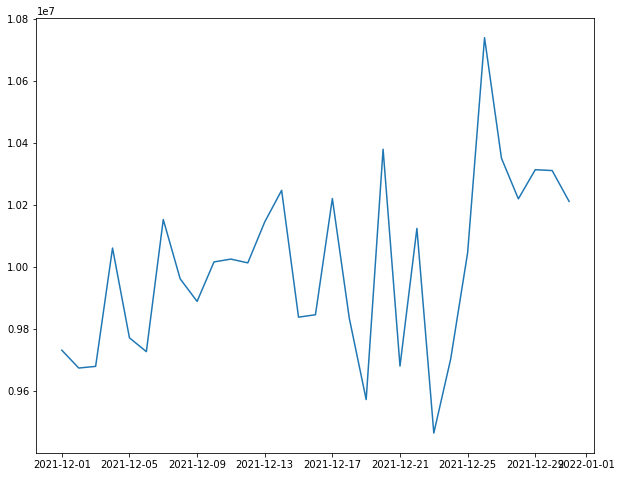

In [238]:
for i in range(1, 13):
    plt.figure(figsize=(10,8))
    plt.plot(df[df['date'].dt.month == i]['date'], df[df['date'].dt.month == i]['receipt_count'])
    plt.show()

### There seems no indication of strong seasonality, but we can still extract the trend component from the data.

## Linear regression (detrend) + Xgboost?

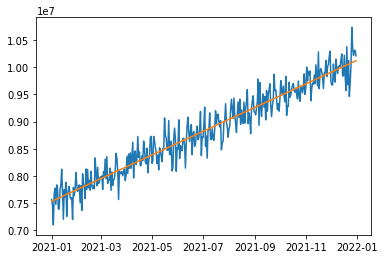

In [239]:
lr = LinearRegression()
timestamps = pd.Series(list(range(1, len(df) + 1))).values.reshape(-1, 1)
lr.fit(timestamps, df['receipt_count'])
y_fit = lr.predict(timestamps)
y_residual = df['receipt_count'] - y_fit
plt.plot(df['date'], df['receipt_count'])
plt.plot(df['date'], y_fit)

### Detrended data, we will feed this into Xgboost

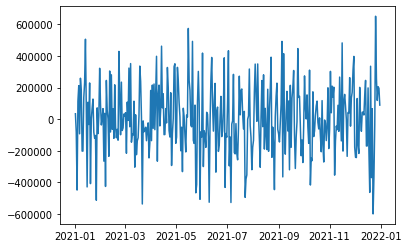

In [240]:
plt.plot(df['date'], y_residual)

### Autocorrelation and partial autocorrelation plot?

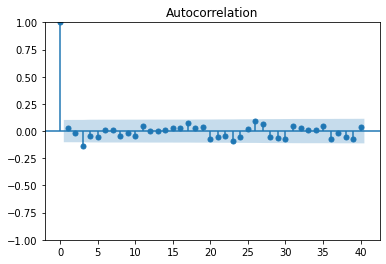

In [241]:
sm.graphics.tsa.plot_acf(y_residual, lags=40);

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


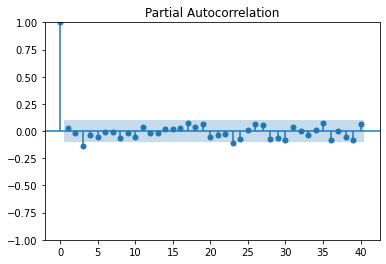

In [242]:
sm.graphics.tsa.plot_pacf(y_residual, lags=40);

### ^ From the acf and pacf plot we can see that there's not any significant correlation between current and past receipt counts, which seems suggest that the detrended data is like white noise.

In [243]:
np.average(y_residual)

-3.572196176607315e-11

(array([ 7., 16., 25., 65., 93., 71., 50., 26., 10.,  2.]),
 array([-600798.88638898, -475514.306793  , -350229.72719702,
        -224945.14760105,  -99660.56800507,   25624.0115909 ,
         150908.59118688,  276193.17078285,  401477.75037883,
         526762.3299748 ,  652046.90957078]),
 <BarContainer object of 10 artists>)

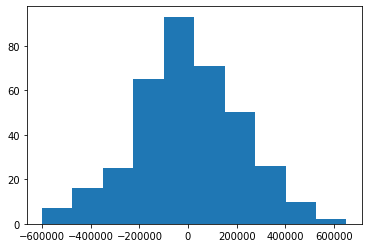

In [244]:
plt.hist(y_residual)

### ^The mean of the detrended data is almost 0 and the data nearly follows standard normal distribution, we have more confidence that it is just white noise.

### Weekly seasonality? (like weekends effect)

In [245]:
weekdays = np.zeros((7, 2))
for i in range(len(df)):
    weekdays[df['date'][i].weekday()][0] += df['receipt_count'][i]
    weekdays[df['date'][i].weekday()][1] += 1

weekdays_avg_count = np.zeros(7)
for i in range(7):
    weekdays_avg_count[i] = weekdays[i][0] / weekdays[i][1]

In [246]:
# Average receipt count on Monday, Tuesday, ..., Sunday
weekdays_avg_count

array([8846047.57692308, 8793656.09615385, 8839170.09615385,
       8840397.40384615, 8827827.73584906, 8841583.90384615,
       8797255.28846154])

### ^ Seems no obvious effect

### So our prediction is simply the predicted value from linear regression plus some white noise

### Train on the first 9 months, test on the last 3 months

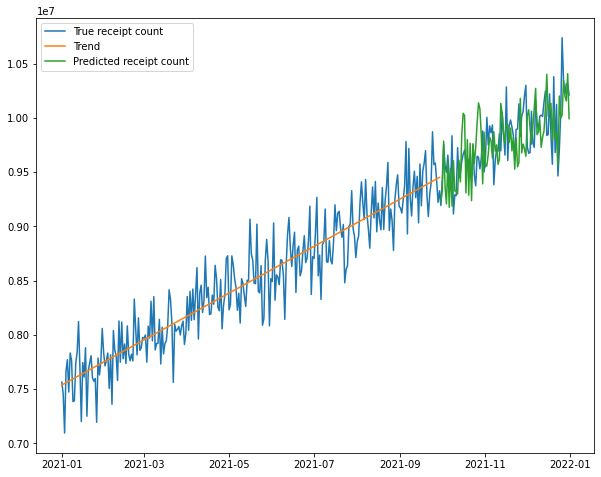

In [247]:
lr_train = LinearRegression()
num_timestamps_train = (date(2021, 9, 30) - date(2021, 1, 1)).days
timestamps_train = pd.Series(list(range(1, num_timestamps_train + 1))).values.reshape(-1, 1)
timestamps_test = pd.Series(list(range(num_timestamps_train + 1, len(df) + 1))).values.reshape(-1, 1)
lr.fit(timestamps_train, df['receipt_count'][0:num_timestamps_train])
y_test = lr.predict(timestamps_test)
y_train_fit = lr.predict(timestamps_train)
y_train_residual = df['receipt_count'][0:num_timestamps_train] - y_train_fit
white_noise_test = np.random.normal(np.average(y_train_residual), np.std(y_train_residual), timestamps_test.shape[0])
y_test += white_noise_test
plt.figure(figsize=(10,8))
plt.plot(df['date'], df['receipt_count'], label='True receipt count')
plt.plot(df['date'][0:num_timestamps_train], y_train_fit, label='Trend')
plt.plot(df['date'][num_timestamps_train:], y_test, label='Predicted receipt count')
plt.legend(loc="upper left")

### ^Not too bad from the graph, let's calculate the MSE and MAE

In [248]:
mean_squared_error(df['receipt_count'][num_timestamps_train:], y_test)

84448053094.83847

In [249]:
mean_absolute_error(df['receipt_count'][num_timestamps_train:], y_test)

235840.9088324286

## Predict for 2022

In [250]:
white_noise = np.random.normal(np.average(y_residual), np.std(y_residual), 365)

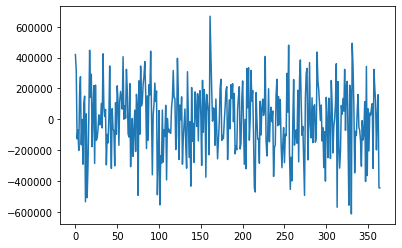

In [251]:
plt.plot(white_noise)

In [252]:
timestamps_2022 = pd.Series(list(range(len(df), len(df) + 365))).values.reshape(-1, 1)

In [253]:
y_pred = lr.predict(timestamps_2022)

In [254]:
predictions = y_pred + white_noise

In [255]:
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
prediction_for_months = []
idx = 0
for days in days_in_month:
    prediction_for_months.append(int(sum(predictions[idx:(idx + days)])))
    idx += days

In [256]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for i in range(12):
    print('Predictions for {} 2022: {}'.format(months[i], prediction_for_months[i]))

Predictions for January 2022: 316455835
Predictions for February 2022: 292576097
Predictions for March 2022: 331035646
Predictions for April 2022: 324206532
Predictions for May 2022: 342271585
Predictions for June 2022: 339387031
Predictions for July 2022: 357227192
Predictions for August 2022: 361933694
Predictions for September 2022: 356640921
Predictions for October 2022: 376266129
Predictions for November 2022: 371048303
Predictions for December 2022: 387853653


Text(0, 0.5, 'Predictions')

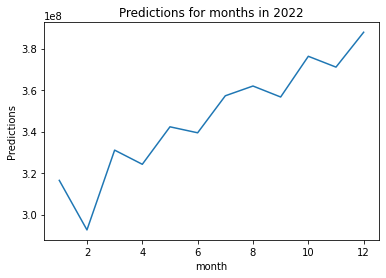

In [257]:
plt.plot(list(range(1, 13)), prediction_for_months)
plt.title('Predictions for months in 2022')
plt.xlabel('month')
plt.ylabel('Predictions')

### ^ Should train on the first 11 months and predic

## Feed the detrended data into Xgboost anyway?

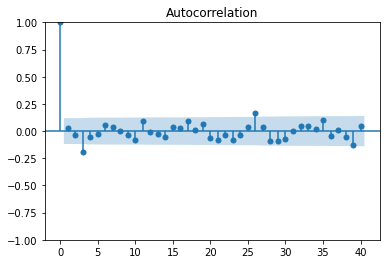

In [258]:
sm.graphics.tsa.plot_acf(y_train_residual, lags=40);

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


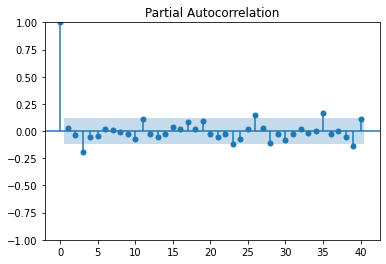

In [259]:
sm.graphics.tsa.plot_pacf(y_train_residual, lags=40);

In [260]:
def xgboost_forecast(df):
    df1 = df.copy()
    # Still, first 9 months as training set and last 3 months as test set.
    num_timestamps_train = (date(2021, 9, 30) - date(2021, 1, 1)).days
    
    lr_train = LinearRegression()
    num_timestamps_train = (date(2021, 9, 30) - date(2021, 1, 1)).days
    timestamps_train = pd.Series(list(range(1, num_timestamps_train + 1))).values.reshape(-1, 1)
    timestamps_test = pd.Series(list(range(num_timestamps_train + 1, len(df) + 1))).values.reshape(-1, 1)
    lr.fit(timestamps_train, df['receipt_count'][0:num_timestamps_train])
    timestamps = pd.Series(list(range(1, len(df) + 1))).values.reshape(-1, 1)
    y_fit = lr.predict(timestamps)
    y_test = y_fit[num_timestamps_train:]
    y_residual = df['receipt_count'] - y_fit
    df1['residual_receipt_count'] = y_residual

    # Features preparation
    num_days = 30 # the number of last days' (lags) daily data to predict the current day.
    df1['day'] = df1['date'].dt.day
    df1['month'] = df1['date'].dt.month
    df1['quarter'] = df1['date'].dt.quarter
    # Lags
    for i in range(1, num_days + 1):
        df1['last_' + str(i) + '_day'] = [0] * i + list(df1['residual_receipt_count'][:-i])
    
    # The first num_days data cannot be used for training
    
    
    # Train-Test split
    train_data = df1[0:num_timestamps_train]
    test_data = df1[num_timestamps_train:]
    X_train = train_data.drop(['receipt_count', 'residual_receipt_count', 'date'], axis=1)
    Y_train = train_data['residual_receipt_count']
    X_test = test_data.drop(['receipt_count', 'residual_receipt_count', 'date'], axis=1)
    
    model = xgb.XGBRegressor(n_estimators=80, max_depth=2)
    model.fit(X_train, Y_train)
    xgb_pred = model.predict(X_test)
    
    y_test += xgb_pred
    return y_test

In [261]:
xgb_prediction = xgboost_forecast(df)
xgb_prediction

array([ 9485817.17909906,  9640683.4817639 ,  9447875.9074756 ,
        9278273.38396856,  9483084.8453248 ,  9322753.95804823,
        9570318.18258806,  9386667.1805654 ,  9500587.11018336,
        9732504.15308256,  9555972.70965365,  9570347.38731848,
        9658039.56107707,  9710864.8168669 ,  9767370.38515673,
        9595227.61750907,  9543660.82837703,  9535316.39080748,
        9550902.95519107,  9414670.4766059 ,  9639881.26364573,
        9718518.01162307,  9600923.31331134,  9639320.65601524,
        9608544.8512582 ,  9604282.20470428,  9626879.56400974,
        9622957.49558082,  9811701.21621441,  9672994.54426986,
        9616344.66529407,  9888070.9523339 ,  9604326.80187374,
        9659427.2314917 ,  9845849.53220341,  9581410.51455574,
        9571937.66878307,  9714799.55592056,  9775594.55926899,
        9724236.95763695,  9738662.78276272,  9762108.01804474,
        9979115.06289708,  9873752.23274941,  9735159.77760174,
        9835273.77948533,  9707539.11730

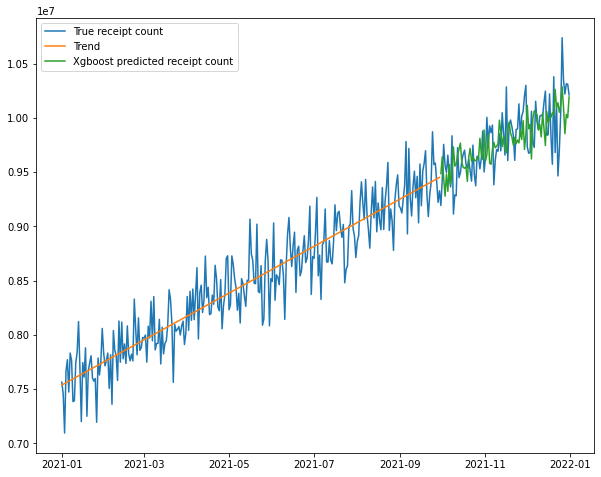

In [262]:
plt.figure(figsize=(10,8))
plt.plot(df['date'], df['receipt_count'], label='True receipt count')
plt.plot(df['date'][0:num_timestamps_train], y_train_fit, label='Trend')
plt.plot(df['date'][num_timestamps_train:], xgb_prediction, label='Xgboost predicted receipt count')
plt.legend(loc="upper left")

In [263]:
mean_squared_error(df['receipt_count'][num_timestamps_train:], xgb_prediction)

71201746684.05238

In [264]:
mean_absolute_error(df['receipt_count'][num_timestamps_train:], xgb_prediction)

215072.57413351495

### ^ There seems no obvious improvement compared with simply linear trend + sampling from white noise.

### Therefore, again, our prediction is simply the predicted value from linear regression plus some white noise. The result is:

In [265]:
for i in range(12):
    print('Predictions for {} 2022: {}'.format(months[i], prediction_for_months[i]))

Predictions for January 2022: 316455835
Predictions for February 2022: 292576097
Predictions for March 2022: 331035646
Predictions for April 2022: 324206532
Predictions for May 2022: 342271585
Predictions for June 2022: 339387031
Predictions for July 2022: 357227192
Predictions for August 2022: 361933694
Predictions for September 2022: 356640921
Predictions for October 2022: 376266129
Predictions for November 2022: 371048303
Predictions for December 2022: 387853653


Text(0, 0.5, 'Predictions')

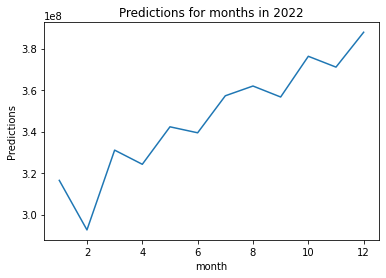

In [266]:
plt.plot(list(range(1, 13)), prediction_for_months)
plt.title('Predictions for months in 2022')
plt.xlabel('month')
plt.ylabel('Predictions')